In [ ]:
pip install ete3

In [3]:
from ete3 import Tree
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# **first_code**

In [ ]:
vertices = []
vertices_no = 0
graph = []
edge_frequencies = defaultdict(int)
all_internal_nodes = []


def identify_nodes(tree):
    leaf_nodes = []
    for node in tree.traverse("postorder"):
        if node.is_leaf():
            leaf_nodes.append(node.name)
    return leaf_nodes


def add_vertex(v):
    global graph
    global vertices_no
    global vertices
    if v not in vertices:
      vertices_no = vertices_no + 1
      vertices.append(v)
      if vertices_no > 1:
          for vertex in graph:
              vertex.append(0)
      temp = []
      for i in range(vertices_no):
          temp.append(0)
      graph.append(temp)

def add_edge(v1, v2, e):
    global graph
    global vertices_no
    global vertices
    edge_frequencies[(v1, v2)] += 1
    edge_frequencies[(v2, v1)] += 1  # Assuming an undirected graph
    index1 = vertices.index(v1)
    index2 = vertices.index(v2)
    # Check if an edge already exists between v1 and v2
    if graph[index1][index2] != 0:
        existing_weight = graph[index1][index2]
        # new_weight = (existing_weight + e) / 2
        new_weight = existing_weight + e
        #new_weight = round(new_weight, 2)
        graph[index1][index2] = new_weight
    else:
        graph[index1][index2] = e


def update_internal_node_names(tree, leaf_nodes):
    internal_nodes = []
    def update_internal_node(node):
        if not node.is_leaf():
            children_names = sorted([child.name for child in node.children])
            new_name = ''.join(children_names)
            new_name = ''.join(sorted(new_name))
            if new_name in leaf_nodes:
                new_name = generate_unique_name(new_name)
            node.name = new_name
            internal_nodes.append(node.name)
            if node.name not in all_internal_nodes:
              all_internal_nodes.append(node.name)

    def generate_unique_name(name):
        # Generate a unique name by adding a suffix
        suffix = 1
        while name + str(suffix) in leaf_nodes:
            suffix += 1
        return name + str(suffix)

    for node in tree.traverse("postorder"):
        update_internal_node(node)
    return internal_nodes


def calculate_distance_matrices(tree):
    # Get a list of all unique nodes (leaves and internal nodes)
    unique_nodes = set(tree.iter_leaves())
    unique_nodes.update(tree.traverse("preorder"))

    # Create a matrix to represent the distances
    node_names = [node.name for node in unique_nodes]  # Define node_names here
    node_names.sort(key=lambda x: (tree & x).get_distance(tree))
    # Initialize a dictionary to store distances between nodes
    distance_matrix = []
    distances = {}
    for node in node_names:
        add_vertex(node)
    # Calculate distances
    for node1 in unique_nodes:
        for node2 in unique_nodes:
            if node1 != node2:
                distance = node1.get_distance(node2)
                distances[(node1.name, node2.name)] = distance
    # add edge
    for node1 in node_names:
        for node2 in node_names:
            if node1 != node2:
                distance1 = distances.get((node1, node2), 0)
                distance1 = round(distance1, 2)
                add_edge(node1, node2, distance1)

    for node1 in node_names:
        row = [distances.get((node1, node2), 0) for node2 in node_names]
        distance_matrix.append(row)
    distance_matrix = [[round(value, 2) for value in row] for row in distance_matrix]

    condensed_distance_matrix = []
    for i in range(len(node_names)):
        row = [distances.get((node_names[i], node_names[j]), 0) for j in range(i + 1)]
        condensed_distance_matrix.append(row)

    condensed_distance_matrix = [[round(value, 2) for value in row] for row in condensed_distance_matrix]
    return distance_matrix


input_file = '/content/Input_tree.txt'
with open(input_file, 'r') as file:
    for idx, line in enumerate(file, 1):
        tree = Tree(line.strip(), format=1)
        leaf_nodes = identify_nodes(tree)
        # print(leaf_nodes)
        internal_nodes = update_internal_node_names(tree,leaf_nodes)
        # print(internal_nodes)
        distance_matrix2 = calculate_distance_matrices(tree)

# print('\nnumber of internal nodes:',len(internal_nodes))
print('\nnumber of all internal nodes:',len(all_internal_nodes))
# print('\nall internal nodes:',all_internal_nodes)
# print('\nall vertices:',vertices)
print('\nnumber of vertices:',vertices_no)


# Extract unique node names
nodes = sorted(set(node for edge in edge_frequencies for node in edge))

# Create an empty 2D array filled with zeros
num_nodes = len(nodes)
# print('\nnodes:',nodes)
# print('\nnumber of nodes:',num_nodes)
# print('\nnumber of vertices:',vertices_no)
# Populate the frequency matrix with the values from the dictionary
frequency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
for i in range(num_nodes):
    for j in range(num_nodes):
        node_i, node_j = nodes[i], nodes[j]
        if (node_i, node_j) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_i, node_j)]
        elif (node_j, node_i) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_j, node_i)]  # Assuming an undirected graph

dist_matrix = [[0 for _ in range(vertices_no)] for _ in range(vertices_no)]
for i in range(vertices_no):
  for j in range(vertices_no):
    if graph[i][j] != 0 and frequency_matrix[i][j] != 0:
      # dist_matrix[i][j] = graph[i][j]
      dist_matrix[i][j] = round(graph[i][j] / frequency_matrix[i][j], 5)



# Define a function to remove cycles from the graph
def remove_cycles(graph):
    G = nx.Graph()

    # Add edges to a NetworkX graph
    for i in range(len(graph)):
        for j in range(i + 1, len(graph[i])):
            weight = graph[i][j]
            if weight != 0:
                G.add_edge(i, j, weight=weight)

    # Find cycles
    cycles = list(nx.cycle_basis(G))
    print('\ncycles are :',cycles)
    # Remove edges in cycles
    for cycle in cycles:
        for i in range(len(cycle)):
            j = (i + 1) % len(cycle)
            u, v = cycle[i], cycle[j]
            if graph[u][v] != 0:
                graph[u][v] = 0



# Define a function to remove duplicate edges
def remove_duplicates(graph):
    for i in range(len(graph)):
        for j in range(i + 1, len(graph[i])):
            if graph[i][j] == 0:
                continue
            if graph[i][j] != graph[j][i] and graph[j][i] != 0:
              print('duplicates are : ',graph[i][j], graph[j][i])
              # Keep the edge with average weight
              first_weight = graph[i][j]
              second_weight = graph[j][i]
              updated_weight = first_weight/second_weight
              updated_weight = round(updated_weight, 2)
              graph[i][j] = updated_weight
              graph[j][i] = 0


# def modified_prims(graph, frequencies, internal_nodes):
#     num_nodes = len(graph)
#     mst = []
#     in_mst = [False] * num_nodes

#     # Create a mapping from node names to indices
#     node_name_to_index = {name: index for index, name in enumerate(vertices)}

#     # Debugging: Print the mappings and input lists
#     print("Vertices:", vertices)
#     print("Internal Nodes:", internal_nodes)
#     print("Node Name to Index Mapping:", node_name_to_index)

#     # Start from the first node of interest.
#     start_node = internal_nodes[0]

#     # Handle case where start_node might not be in the mapping
#     if start_node not in node_name_to_index:
#         print(f"Start node '{start_node}' not found in node_name_to_index mapping.")
#         return []  # or handle this case as needed

#     # Convert start_node from a name to an index
#     start_node_index = node_name_to_index[start_node]

#     # Use this index in your MST algorithm
#     in_mst[start_node_index] = True

#     while len(mst) < len(internal_nodes) - 1:
#         max_frequency = -1
#         chosen_edge = (None, None, float('inf'))  # Initialize with placeholder values

#         for node_name in internal_nodes:
#             node_index = node_name_to_index[node_name]
#             if in_mst[node_index]:
#                 for neighbor_index, edge_weight in enumerate(graph[node_index]):
#                     neighbor_name = vertices[neighbor_index]  # Get the name of the neighbor
#                     if neighbor_name in internal_nodes and not in_mst[neighbor_index]:
#                         frequency = frequencies[node_index][neighbor_index]
#                         # if frequency >= max_frequency and edge_weight < chosen_edge[2]:
#                         if frequency >= max_frequency:
#                             max_frequency = frequency
#                             # Store indices instead of names
#                             chosen_edge = (node_index, neighbor_index, edge_weight)

#         # After the loop, update in_mst and mst using indices
#         # print("Chosen edge:", chosen_edge)
#         # print("Type of chosen_edge[1]:", type(chosen_edge[1]))
#         if chosen_edge[0] is not None and chosen_edge[1] is not None:
#             # Use index for in_mst
#             in_mst[chosen_edge[1]] = True
#             # Convert indices back to names for mst
#             # mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]]))
#             mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]], chosen_edge[2]))


#     return mst


def modified_prims(graph, frequencies, internal_nodes, degrees):
    num_nodes = len(graph)
    mst = []
    in_mst = [False] * num_nodes

    # Create a mapping from node names to indices
    node_name_to_index = {name: index for index, name in enumerate(vertices)}

    # Debugging: Print the mappings and input lists
    print("Vertices:", vertices)
    print("Internal Nodes:", internal_nodes)
    print("Node Name to Index Mapping:", node_name_to_index)

    # Start from the first node of interest.
    start_node = internal_nodes[0]

    # Handle case where start_node might not be in the mapping
    if start_node not in node_name_to_index:
        print(f"Start node '{start_node}' not found in node_name_to_index mapping.")
        return []  # or handle this case as needed

    # Convert start_node from a name to an index
    start_node_index = node_name_to_index[start_node]

    # Use this index in your MST algorithm
    in_mst[start_node_index] = True

    while len(mst) < len(internal_nodes) - 1:
        max_degree = -1
        max_frequency = -1
        chosen_edge = (None, None, float('inf'))  # Initialize with placeholder values

        for node_name in internal_nodes:
            node_index = node_name_to_index[node_name]
            if in_mst[node_index]:
                for neighbor_index, edge_weight in enumerate(graph[node_index]):
                    neighbor_name = vertices[neighbor_index]  # Get the name of the neighbor
                    if neighbor_name in internal_nodes and not in_mst[neighbor_index]:
                        frequency = frequencies[node_index][neighbor_index]
                        degree = degrees[neighbor_index]

                        # Check degree first, then frequency, then edge weight
                        if degree > max_degree:
                            max_degree = degree
                            max_frequency = frequency
                            chosen_edge = (node_index, neighbor_index, edge_weight)
                        elif degree == max_degree:
                            if frequency > max_frequency:
                                max_frequency = frequency
                                chosen_edge = (node_index, neighbor_index, edge_weight)
                            elif frequency == max_frequency and edge_weight < chosen_edge[2]:
                                chosen_edge = (node_index, neighbor_index, edge_weight)

        # After the loop, update in_mst and mst using indices
        # print("Chosen edge:", chosen_edge)
        # print("Type of chosen_edge[1]:", type(chosen_edge[1]))
        if chosen_edge[0] is not None and chosen_edge[1] is not None:
            # Use index for in_mst
            in_mst[chosen_edge[1]] = True
            # Convert indices back to names for mst
            # mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]]))
            mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]], chosen_edge[2]))

    return mst



def draw_mst(mst_G):
    # Draw the graph
    pos = nx.spring_layout(mst_G)  # Layout algorithm (you can choose another one)

    # Increase the figure size (adjust the width and height as needed)
    plt.figure(figsize=(15, 15))

    # Customize node and edge visual properties for clarity
    nx.draw(mst_G, pos, with_labels=True, node_size=30, node_color='skyblue', font_size=8, font_color='black', edge_color='gray', width=0.8)

    # Display the graph
    plt.axis('off')
    plt.show()

# Call the function to remove cycles from the graph
remove_cycles(graph)

# Call the function to remove duplicate edges
remove_duplicates(graph)

# Call the modified_prims function with the specified nodes
mst_result = modified_prims(dist_matrix, frequency_matrix, all_internal_nodes)
# print('\nMST :',mst_result)
mst_G = nx.Graph()
for edge in mst_result:
    node1, node2, distance = edge
    mst_G.add_edge(node1, node2, weight=distance)
    # mst_G.add_edge(edge[0], edge[1])
    # print(node1, node2,'->', distance)
# draw_mst(mst_G)

# Assuming result is already obtained from modified_prims function
G = nx.Graph()
for edge in mst_result:
    #G.add_edge(edge[0], edge[1])
    node1, node2, distance = edge
    G.add_edge(node1, node2, weight=distance)
# Create a mapping from node names to indices
node_name_to_index = {name: index for index, name in enumerate(vertices)}
# Assuming dist_matrix is a 2D array-like structure with distances between nodes
# and node_name_to_index is a dictionary mapping node names to their indices in dist_matrix
for leaf in leaf_nodes:
    leaf_index = node_name_to_index[leaf]
    nearest_internal_node = None
    min_distance = float('inf')
    max_freq = -1
    for internal_node in all_internal_nodes:
        internal_node_index = node_name_to_index[internal_node]
        distance = dist_matrix[leaf_index][internal_node_index]
        freq = frequency_matrix[leaf_index][internal_node_index]
        # if distance < min_distance:
        if freq > max_freq:
            nearest_internal_node = internal_node
        elif freq == max_freq:
          if distance < min_distance:
              min_distance = distance
              nearest_internal_node = internal_node

    if nearest_internal_node is not None:
        G.add_edge(leaf, nearest_internal_node,weight=distance)

# Now G contains the original MST with leaf nodes connected to the nearest internal nodes

# Create a set of leaf nodes for faster lookup
leaf_node_set = set(leaf_nodes)

# Iterate over a copy of the internal nodes list to avoid modification during iteration
for internal_node in all_internal_nodes[:]:
    # Check the neighbors of the internal node
    neighbors = list(G.neighbors(internal_node))

    # Check if the internal node is connected only to one other internal node and no leaf nodes
    if len(neighbors) == 1 and neighbors[0] in all_internal_nodes and not any(neighbor in leaf_node_set for neighbor in neighbors):
        G.remove_node(internal_node)
        all_internal_nodes.remove(internal_node)
    # New condition: if the internal node is connected to exactly one leaf node and one internal node
    elif len(neighbors) == 2 and any(neighbor in leaf_node_set for neighbor in neighbors) and any(neighbor in all_internal_nodes for neighbor in neighbors):
        # Identify the leaf node and the other internal node
        leaf_node = next(neighbor for neighbor in neighbors if neighbor in leaf_node_set)
        other_internal_node = next(neighbor for neighbor in neighbors if neighbor in all_internal_nodes)

        # Calculate the new branch length as the sum of distances from the distance matrix
        new_branch_length = dist_matrix[node_name_to_index[internal_node]][node_name_to_index[leaf_node]] + dist_matrix[node_name_to_index[internal_node]][node_name_to_index[other_internal_node]]

        # Remove the internal node
        G.remove_node(internal_node)

        # Add an edge between the leaf node and the other internal node with the new branch length
        # Note: You might need to adjust this part if your graph G does not store weights
        G.add_edge(leaf_node, other_internal_node, weight=new_branch_length)

        all_internal_nodes.remove(internal_node)  # Optional: update the internal nodes list

# Now G contains only the internal nodes that are connected to leaf nodes or more than one internal node

# **2nd code**


   /-e
--|
  |   /-a
   \-|
     |   /-d
      \-|
        |   /-b
         \-|
            \-c
['abcde', 'abcd', 'e', 'a', 'bcd', 'd', 'bc', 'b', 'c']


Tree nodes conection :  abcde - abcd - 0 

abcde  to  abcd 




Tree nodes conection :  abcde - e - 0 

abcde  to  e 




Tree nodes conection :  abcd - a - 0 

abcd  to  a 




Tree nodes conection :  abcd - bcd - 0 

abcd  to  bcd 




Tree nodes conection :  bcd - d - 0 

bcd  to  d 




Tree nodes conection :  bcd - bc - 0 

bcd  to  bc 




Tree nodes conection :  bc - b - 0 

bc  to  b 




Tree nodes conection :  bc - c - 0 

bc  to  c 



   /-e
--|
  |   /-d
   \-|
     |   /-a
      \-|
        |   /-b
         \-|
            \-c
['abcde', 'abcd', 'e', 'd', 'abc', 'a', 'bc', 'b', 'c']


Tree nodes conection :  abcde - abcd - 0 

abcde  to  abcd 




Tree nodes conection :  abcde - e - 0 

abcde  to  e 




Tree nodes conection :  abcd - d - 0 

abcd  to  d 




Tree nodes conection :  abcd - abc - 0 

abcd  to  abc 




Tr

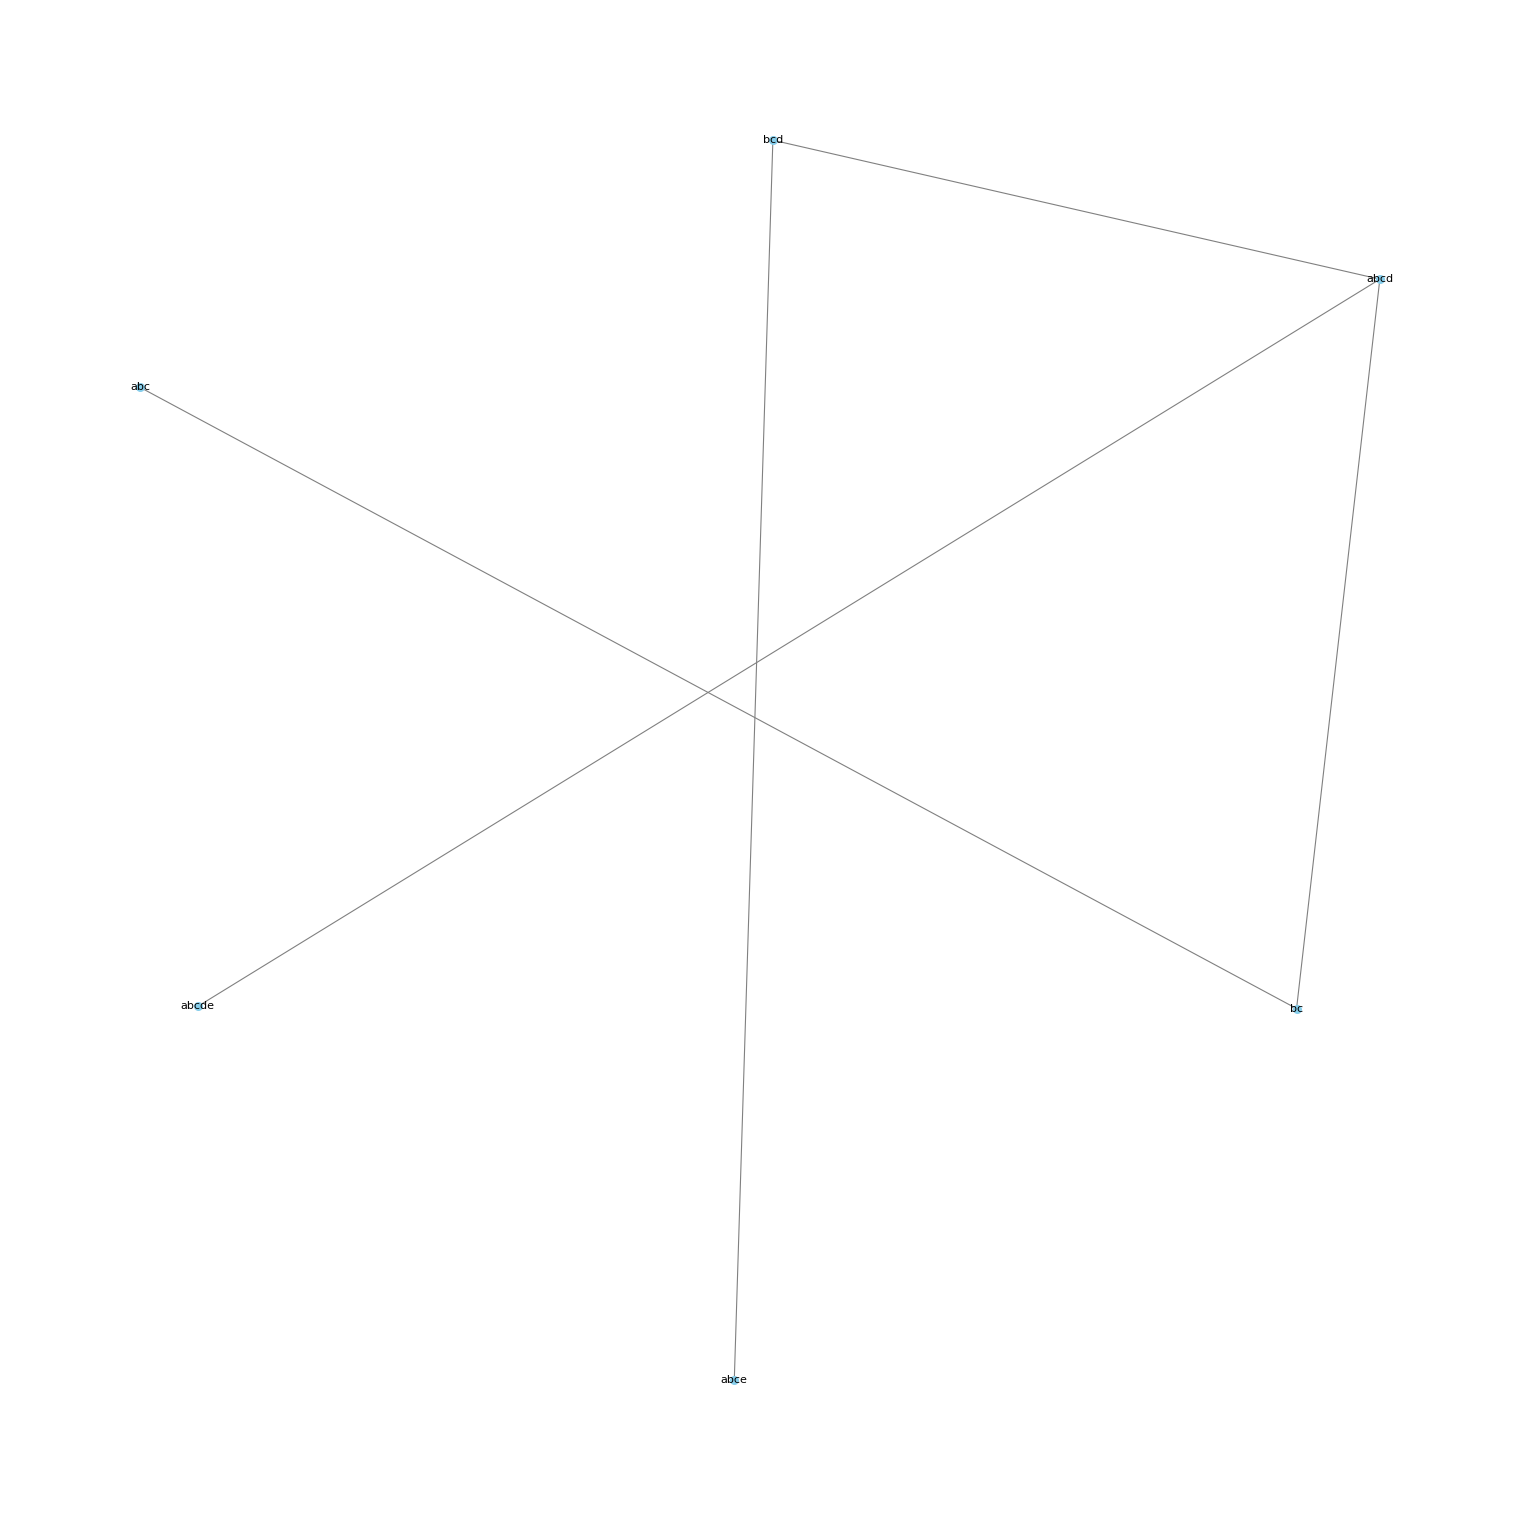

In [52]:
vertices = []
vertices_no = 0
graph = []
edge_frequencies = defaultdict(int)
all_internal_nodes = []
in_degrees = []

def identify_nodes(tree):
    leaf_nodes = []
    for node in tree.traverse("postorder"):
        if node.is_leaf():
            leaf_nodes.append(node.name)
    return leaf_nodes


def add_vertex(v):
    global graph
    global vertices_no
    global vertices
    global in_degrees
    if v not in vertices:
      vertices_no = vertices_no + 1
      vertices.append(v)
      in_degrees.append(0)
      if vertices_no > 1:
          for vertex in graph:
              vertex.append(0)
      graph.append([0] * vertices_no)





def add_edge(v1, v2, e):
    global graph
    global vertices_no
    global vertices
    global in_degrees
    edge_frequencies[(v1, v2)] += 1
    edge_frequencies[(v2, v1)] += 1  # Assuming an undirected graph
    index1 = vertices.index(v1)
    index2 = vertices.index(v2)
    # Check if an edge already exists between v1 and v2
    if graph[index1][index2] != 0:
        graph[index1][index2] = graph[index1][index2] + e
        in_degrees[index2] += 1
        print(v1," to ", v2, " more than once\n\n")
    else:
        graph[index1][index2] = e
        in_degrees[index2] += 1
        print(v1," to ", v2, "\n\n")


def update_internal_node_names(tree, leaf_nodes):
    internal_nodes = []
    def update_internal_node(node):
        if not node.is_leaf():
            children_names = sorted([child.name for child in node.children])
            new_name = ''.join(children_names)
            new_name = ''.join(sorted(new_name))
            if new_name in leaf_nodes:
                new_name = generate_unique_name(new_name)
            node.name = new_name
            internal_nodes.append(node.name)
            if node.name not in all_internal_nodes:
              all_internal_nodes.append(node.name)

    def generate_unique_name(name):
        # Generate a unique name by adding a suffix
        suffix = 1
        while name + str(suffix) in leaf_nodes:
            suffix += 1
        return name + str(suffix)

    for node in tree.traverse("postorder"):
        update_internal_node(node)
    return internal_nodes

def has_direct_connection(tree, parent, child):
    """Check if 'child' is a direct child of 'parent' in the given tree."""
    # Find the parent node using its name
    parent_node = tree.search_nodes(name=parent)
    if not parent_node:
        print(f"No parent node found with name: {parent}")
        return False
    parent_node = parent_node[0]  # Assuming unique names and taking the first match

    # Check if any direct child of this node is the child
    return any(c.name == child for c in parent_node.children)

def check_direct_connection(tree, name1, name2):
    # Find the nodes by name
    node1 = tree.search_nodes(name=name1)
    node2 = tree.search_nodes(name=name2)

    if not node1 or not node2:
        print("they does not exits")
        return False  # One of the nodes does not exist

    node1 = node1[0]
    node2 = node2[0]

    # Check if node1 is the parent of node2 or vice versa
    if node1.up == node2 or node2.up == node1:
        return True
    return False

def calculate_distance_matrices(tree):
    # Get a list of all unique nodes (leaves and internal nodes)
    print(tree)
    unique_nodes = set(tree.iter_leaves())
    unique_nodes.update(tree.traverse("preorder"))

    # Create a matrix to represent the distances
    node_names = [node.name for node in unique_nodes]  # Define node_names here
    node_names.sort(key=lambda x: (tree & x).get_distance(tree))
    print(node_names)
    # Initialize a dictionary to store distances between nodes
    distance_matrix = []
    distances = {}

    for node in node_names:
        add_vertex(node)

    # Calculate distances
    # add edge
    for i in range(0, len(node_names)):
        for j in range(i + 1, len(node_names)):
            v1 = node_names[i]
            v2 = node_names[j]
            if check_direct_connection(tree, v1,v2):
                distance1 = round(distances.get((v1, v2), 0), 2)
                print("\n\nTree nodes conection : ",v1,"-",v2,"-",distance1,"\n")
                add_edge(v1, v2, distance1)


    for node1 in node_names:
        row = [distances.get((node1, node2), 0) for node2 in node_names]
        distance_matrix.append(row)
    distance_matrix = [[round(value, 2) for value in row] for row in distance_matrix]

    condensed_distance_matrix = []
    for i in range(len(node_names)):
        row = [distances.get((node_names[i], node_names[j]), 0) for j in range(i + 1)]
        condensed_distance_matrix.append(row)

    condensed_distance_matrix = [[round(value, 2) for value in row] for row in condensed_distance_matrix]
    return distance_matrix


input_file = '/content/example_tree.txt'
with open(input_file, 'r') as file:
    for idx, line in enumerate(file, 1):
        tree = Tree(line.strip(), format=1)
        leaf_nodes = identify_nodes(tree)
        # print(leaf_nodes)
        internal_nodes = update_internal_node_names(tree,leaf_nodes)
        # print(internal_nodes)
        distance_matrix2 = calculate_distance_matrices(tree)


print("Combined Graph In-degrees:", in_degrees)

print('\nnumber of internal nodes:',len(internal_nodes))
print('\nnumber of all internal nodes:',len(all_internal_nodes))
print('\nall internal nodes:',all_internal_nodes)
print('\nall vertices:',vertices)
print('\nnumber of vertices:',vertices_no)


# Extract unique node names
nodes = sorted(set(node for edge in edge_frequencies for node in edge))

# Create an empty 2D array filled with zeros
num_nodes = len(nodes)
print('\nnodes:',nodes)
print('\nnumber of nodes:',num_nodes)
print('\nnumber of vertices:',vertices_no)

# Populate the frequency matrix with the values from the dictionary
frequency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
for i in range(num_nodes):
    for j in range(num_nodes):
        node_i, node_j = nodes[i], nodes[j]
        if (node_i, node_j) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_i, node_j)]
        elif (node_j, node_i) in edge_frequencies:
            frequency_matrix[i][j] = edge_frequencies[(node_j, node_i)]  # Assuming an undirected graph

dist_matrix = [[0 for _ in range(vertices_no)] for _ in range(vertices_no)]
for i in range(vertices_no):
  for j in range(vertices_no):
    if graph[i][j] != 0 and frequency_matrix[i][j] != 0:
      # dist_matrix[i][j] = graph[i][j]
      dist_matrix[i][j] = round(graph[i][j] / frequency_matrix[i][j], 2)



def modified_prims(graph, frequencies, internal_nodes, degrees):
    num_nodes = len(graph)
    print("graph len: ", num_nodes)
    mst = []
    in_mst = [False] * num_nodes

    # Create a mapping from node names to indices
    node_name_to_index = {name: index for index, name in enumerate(vertices)}

    # Debugging: Print the mappings and input lists
    print("Vertices:", vertices)
    print("Internal Nodes:", internal_nodes)
    print("Node Name to Index Mapping:", node_name_to_index)

    # Start from the first node of interest.
    start_node = internal_nodes[0]
    print("start_node", start_node)
    # Handle case where start_node might not be in the mapping
    if start_node not in node_name_to_index:
        print(f"Start node '{start_node}' not found in node_name_to_index mapping.")
        return []  # or handle this case as needed

    # Convert start_node from a name to an index
    start_node_index = node_name_to_index[start_node]
    print("start_node_index", start_node_index)
    # Use this index in your MST algorithm
    in_mst[start_node_index] = True

    while len(mst) < len(internal_nodes) - 1:
        max_degree = -1
        max_frequency = -1
        chosen_edge = (None, None, float('inf'))  # Initialize with placeholder values

        for node_name in internal_nodes:
            node_index = node_name_to_index[node_name]
            if in_mst[node_index]:
                for neighbor_index, edge_weight in enumerate(graph[node_index]):
                    neighbor_name = vertices[neighbor_index]  # Get the name of the neighbor
                    if neighbor_name in internal_nodes and not in_mst[neighbor_index]:
                        frequency = frequencies[node_index][neighbor_index]
                        degree = degrees[neighbor_index]

                        # Check degree first, then frequency, then edge weight
                        if degree > max_degree:
                            max_degree = degree
                            max_frequency = frequency
                            chosen_edge = (node_index, neighbor_index, edge_weight)
                        elif degree == max_degree:
                            if frequency > max_frequency:
                                max_frequency = frequency
                                chosen_edge = (node_index, neighbor_index, edge_weight)
                            elif frequency == max_frequency and edge_weight < chosen_edge[2]:
                                chosen_edge = (node_index, neighbor_index, edge_weight)

        # After the loop, update in_mst and mst using indices
        print("\n\nChosen edge: ", chosen_edge)
        # print("Type of chosen_edge[1]:", type(chosen_edge[1]))
        if chosen_edge[0] is not None and chosen_edge[1] is not None:
            # Use index for in_mst
            in_mst[chosen_edge[1]] = True
            # Convert indices back to names for mst
            # mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]]))
            mst.append((vertices[chosen_edge[0]], vertices[chosen_edge[1]], chosen_edge[2]))

    return mst



def draw_mst(mst_G):
    # Draw the graph
    pos = nx.spring_layout(mst_G)  # Layout algorithm (you can choose another one)

    # Increase the figure size (adjust the width and height as needed)
    plt.figure(figsize=(15, 15))

    # Customize node and edge visual properties for clarity
    nx.draw(mst_G, pos, with_labels=True, node_size=30, node_color='skyblue', font_size=8, font_color='black', edge_color='gray', width=0.8)

    # Display the graph
    plt.axis('off')
    plt.show()

# Call the function to remove cycles from the graph
# remove_cycles(graph)

# Call the function to remove duplicate edges
# remove_duplicates(graph)


# Call the modified_prims function with the specified nodes
mst_result = modified_prims(graph, frequency_matrix, all_internal_nodes, in_degrees)
print("\n\nmst: ", mst_result)

# print('\nMST :',mst_result)
mst_G = nx.Graph()
for edge in mst_result:
    node1, node2, distance = edge
    mst_G.add_edge(node1, node2, weight=distance)
    # mst_G.add_edge(edge[0], edge[1])
    # print(node1, node2,'->', distance)
# draw_mst(mst_G)

# Assuming result is already obtained from modified_prims function
G = nx.Graph()
for edge in mst_result:
    #G.add_edge(edge[0], edge[1])
    node1, node2, distance = edge
    G.add_edge(node1, node2, weight=distance)
# Create a mapping from node names to indices
node_name_to_index = {name: index for index, name in enumerate(vertices)}
# Assuming dist_matrix is a 2D array-like structure with distances between nodes
# and node_name_to_index is a dictionary mapping node names to their indices in dist_matrix
for leaf in leaf_nodes:
    leaf_index = node_name_to_index[leaf]
    nearest_internal_node = None
    min_distance = float('inf')
    max_freq = -1
    for internal_node in all_internal_nodes:
        internal_node_index = node_name_to_index[internal_node]
        distance = dist_matrix[leaf_index][internal_node_index]
        freq = frequency_matrix[leaf_index][internal_node_index]
        # if distance < min_distance:
        if freq > max_freq:
            nearest_internal_node = internal_node
        elif freq == max_freq:
          if distance < min_distance:
              min_distance = distance
              nearest_internal_node = internal_node

    if nearest_internal_node is not None:
        G.add_edge(leaf, nearest_internal_node,weight=distance)

# Now G contains the original MST with leaf nodes connected to the nearest internal nodes

# Create a set of leaf nodes for faster lookup
leaf_node_set = set(leaf_nodes)

# Iterate over a copy of the internal nodes list to avoid modification during iteration
for internal_node in all_internal_nodes[:]:
    # Check the neighbors of the internal node
    neighbors = list(G.neighbors(internal_node))

    # Check if the internal node is connected only to one other internal node and no leaf nodes
    if len(neighbors) == 1 and neighbors[0] in all_internal_nodes and not any(neighbor in leaf_node_set for neighbor in neighbors):
        G.remove_node(internal_node)
        all_internal_nodes.remove(internal_node)
    # New condition: if the internal node is connected to exactly one leaf node and one internal node
    elif len(neighbors) == 2 and any(neighbor in leaf_node_set for neighbor in neighbors) and any(neighbor in all_internal_nodes for neighbor in neighbors):
        # Identify the leaf node and the other internal node
        leaf_node = next(neighbor for neighbor in neighbors if neighbor in leaf_node_set)
        other_internal_node = next(neighbor for neighbor in neighbors if neighbor in all_internal_nodes)

        # Calculate the new branch length as the sum of distances from the distance matrix
        new_branch_length = dist_matrix[node_name_to_index[internal_node]][node_name_to_index[leaf_node]] + dist_matrix[node_name_to_index[internal_node]][node_name_to_index[other_internal_node]]

        # Remove the internal node
        G.remove_node(internal_node)

        # Add an edge between the leaf node and the other internal node with the new branch length
        # Note: You might need to adjust this part if your graph G does not store weights
        G.add_edge(leaf_node, other_internal_node, weight=new_branch_length)

        all_internal_nodes.remove(internal_node)  # Optional: update the internal nodes list

# Now G contains only the internal nodes that are connected to leaf nodes or more than one internal node

In [46]:
# Print all edges and their weights
for edge in G.edges(data=True):
    node1, node2, weight = edge
    print(f"Edge: {node1} - {node2}, Weight: {weight['weight']}")

Edge: bc - abcd, Weight: 0
Edge: bc - abc, Weight: 0
Edge: abc - bcd, Weight: 0
Edge: bcd - abce, Weight: 0
Edge: abce - d, Weight: 0
Edge: abce - e, Weight: 0
Edge: abce - a, Weight: 0
Edge: abce - b, Weight: 0
Edge: abce - c, Weight: 0


In [49]:
def networkx_to_ete3(G, root_node):
    if root_node not in G:
        raise ValueError(f"Root node '{root_node}' not found in the graph.")

    visited = set()  # To keep track of visited nodes

    def add_children(node, ete3_node):
        visited.add(node)  # Mark the current node as visited
        for child in G.neighbors(node):
            if child not in visited:
                # Create the child node
                child_node = ete3_node.add_child(name=str(child))

                # Set the branch length (edge weight)
                branch_length = G[node][child].get('weight', 1.0)  # Default to 1.0 if no weight is found
                child_node.dist = branch_length

                # Recursively add children of this node
                add_children(child, child_node)

    root = Tree(name=str(root_node))
    add_children(root_node, root)
    return root

# Example usage
root_node = 'abcd'
ete3_tree = networkx_to_ete3(G, root_node)
print(ete3_tree.write(format=5))

(((((d:0,e:0,a:0,b:0,c:0):0):0):0):0);
